In [25]:
from Package.p2vec import CreateEmbedding
from Package.DCSBM import matrix_C, adj, normalized_mutual_info_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt
import faiss
from scipy.sparse import diags

In [18]:
def computeNMI(Φ, ℓ):
    '''This function computes the NMI as inferred from KMeans applied on the embedding Φ
    
    Use: NMI = computeNMI(Φ, ℓ)
    
    Inputs: 
        * Φ (array): embedding from which the labels should be estimated
        * ℓ (array): true labels
        
    Outpus:
        * NMI (float): normalized mutual information score
    '''

    n_clusters = len(np.unique(ℓ))
    Φ = (Φ.T - np.reshape(np.mean(Φ, axis = 0), (dim, 1))).T 
    Φ = normalize(Φ, norm = 'l2', axis = 1)
    kmeans = faiss.Kmeans(np.shape(Φ)[1], n_clusters, verbose = False)
    kmeans.train(np.ascontiguousarray(Φ).astype('float32'))
    _, ℓest = kmeans.assign(np.ascontiguousarray(Φ).astype('float32'))
    
    return normalized_mutual_info_score(ℓest, ℓ)


In [28]:
# set the parameters to generate the graph
n = 30000
n_clusters = 2
π = np.ones(n_clusters)/n_clusters
c = 7
c_out = 2
fluctuation = 0.
recompute_labels = True

# set the parameters for the embedding algorithm
dim = 32
n_epochs = 20
walk_length = 5
k = 20
γ = 1.
Λ = None
symmetric = True

# generate the label vector
ℓ = np.concatenate([[j for i in range(int(π[j]*n))] for j in range(n_clusters)])
n = len(ℓ)

# generate a broad degree distribution
np.random.seed(0)
θ = np.random.uniform(3,10, n)**6
θ = θ/np.mean(θ)

sq = np.mean(θ**2)
α = (c - c_out)*np.sqrt(sq/c)

# create the C matrix
C = matrix_C(c_out, c, fluctuation, π)

# generate the adjacency matrix
A = adj(C, c, ℓ, θ)

# limit the analysis to the giant component
d = A@np.ones(n)
idx = d > 0
A = A[idx][:,idx]
d = d[idx]
n = len(d)
ℓ = ℓ[idx]

# create the probability matrix
D_1 = diags(d**(-1))
P = D_1.dot(A)

# P2Vec
Pv = [P]

In [29]:
# run 2 models for comparison
try:
    del(p2v1)
except: pass
try:
    del(p2v2)
except: pass

start_time = time.time()
try:
    p2v1 = CreateEmbedding(Pv, Λ = Λ, dim = dim, n_epochs = 20, n_epochs_before_rescheduling = 1, walk_length = walk_length, k = k, η0 = .5, ηfin =10e-5, 
            γ = γ, scheduler_type = 'linear', recompute_labels = recompute_labels, optimizer = None, verbose = True, seed = 123, 
            normalizeΦ=True, clipping = False, rescaleΦ = d, compute_loss= True) 
except Exception as e: print(e)
print("run 1:", time.time() - start_time)

start_time = time.time()
try:
    p2v2 = CreateEmbedding(Pv, Λ = Λ, dim = dim, n_epochs = 20, n_epochs_before_rescheduling = 1, walk_length = walk_length, k = k, η0 = .5, ηfin = 10e-5, 
            γ = γ, scheduler_type = 'linear', recompute_labels = recompute_labels, optimizer = None, verbose = True, seed = 123,
            normalizeΦ= True, clipping = False, rescaleΦ = None, compute_loss= True) 
except Exception as e: print(e)
print("run 2:", time.time() - start_time)


Running the optimization for k = 1
[========================>] 100%, η = 0.000100

Computing the clusters...
Running the optimization for k = 20
[========================>] 100%, η = 0.000100

Computing the parameters values...
run 1: 33.547669649124146
Running the optimization for k = 1
[========================>] 100%, η = 0.000100

Computing the clusters...
Running the optimization for k = 20
[========================>] 100%, η = 0.000100

Computing the parameters values...
run 2: 30.89205574989319


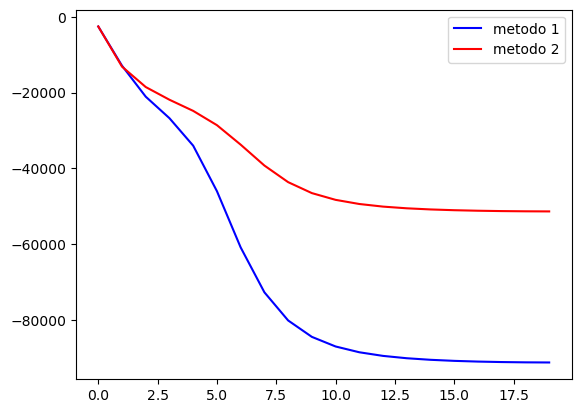

In [30]:
try:
    plt.plot(p2v1.loss, 'b-', label = 'metodo 1')
except: pass

try:
    plt.plot(p2v2.loss, 'r-', label = 'metodo 2')
except: pass

plt.legend()
plt.show();

In [31]:
try:
    print("metodo 1", computeNMI(p2v1.Φ,ℓ))
except: pass
try:
    print("metodo 2", computeNMI(p2v2.Φ,ℓ))
except: pass


metodo 1 0.6957902329568857
metodo 2 0.6978338799888406


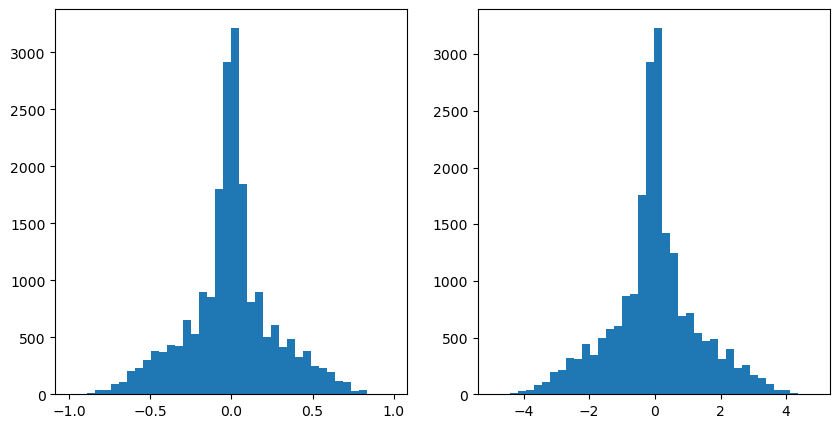

In [34]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
try:
    ax[0].hist(p2v1.Φ[0]@p2v1.Φ.T, bins = 40)
except:
    pass

try:
    ax[1].hist(p2v2.Φ[0]@p2v1.Φ.T, bins = 40)
except:
    pass

plt.show();

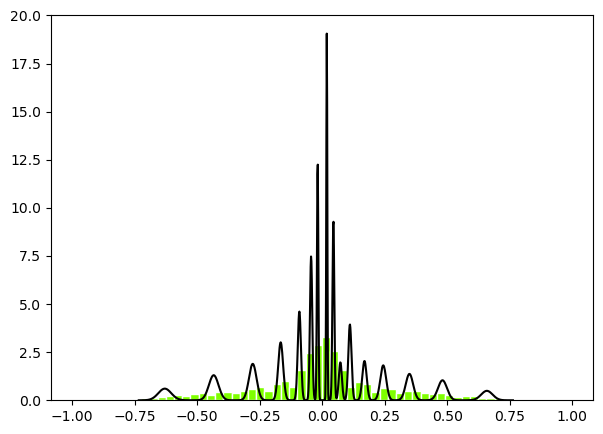

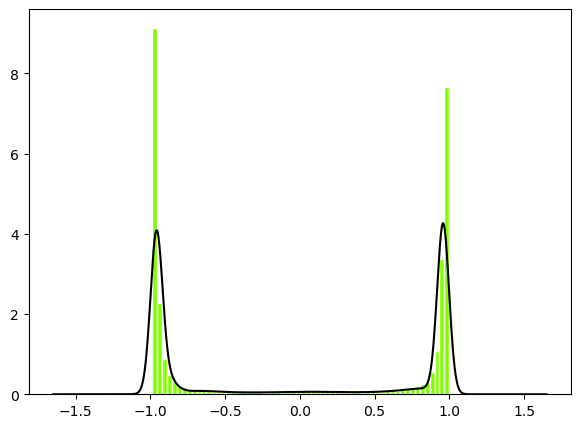

In [39]:
try:
    p2v1.plotDistr(0)
except:
    pass

try:
    p2v2.plotDistr(0)
except:
    pass
